In [ ]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import time
import datetime as dt

import npc_lims
from npc_sessions import DynamicRoutingSession
from dynamic_routing_analysis import data_utils, spike_utils

# plt.rcParams['pdf.fonttype'] = 42 
plt.rcParams.update({'font.size': 8,'pdf.fonttype':42})

%load_ext autoreload
%autoreload 2
%matplotlib widget

In [3]:
all_units=pd.read_parquet(npc_lims.get_cache_path('units',version='0.0.265'))

In [4]:
all_units.columns

Index(['activity_drift', 'amplitude', 'amplitude_cutoff',
       'amplitude_cv_median', 'amplitude_cv_range', 'amplitude_median',
       'ccf_ap', 'ccf_dv', 'ccf_ml', 'channels', 'cluster_id', 'd_prime',
       'decoder_label', 'decoder_probability', 'default_qc', 'drift_mad',
       'drift_ptp', 'drift_std', 'electrode_group_name', 'exp_decay',
       'firing_range', 'firing_rate', 'half_width', 'is_not_drift',
       'isi_violations_count', 'isi_violations_ratio', 'isolation_distance',
       'l_ratio', 'location', 'nn_hit_rate', 'nn_miss_rate',
       'num_negative_peaks', 'num_positive_peaks', 'num_spikes',
       'peak_channel', 'peak_electrode', 'peak_to_valley', 'peak_trough_ratio',
       'peak_waveform_index', 'presence_ratio', 'recovery_slope',
       'repolarization_slope', 'rp_contamination', 'rp_violations',
       'silhouette', 'sliding_rp_violation', 'snr', 'spread', 'structure',
       'unit_id', 'velocity_above', 'velocity_below', 'obs_intervals',
       'electrodes', 

In [85]:
len(all_units['session_id'].unique())

245

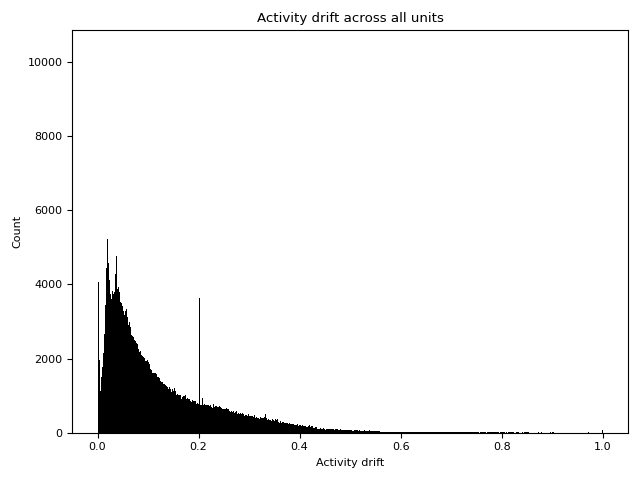

In [86]:
fig,ax=plt.subplots()
ax.hist(all_units['activity_drift'],bins=np.arange(0,1.001,0.001),color='k')
ax.set_title('Activity drift across all units')
ax.set_xlabel('Activity drift')
ax.set_ylabel('Count')
fig.tight_layout()

In [88]:
no_drift_criteria_frac=len(all_units.query('decoder_label!="noise" and isi_violations_ratio<=0.5 and presence_ratio>=0.7 and amplitude_cutoff<=0.1'))/len(all_units)
print(f'Fraction of units passing basic criteria: {no_drift_criteria_frac:.2f}')

loose_drift_criteria_frac=len(all_units.query('activity_drift<=0.2 and decoder_label!="noise" and isi_violations_ratio<=0.5 and presence_ratio>=0.7'))/len(all_units)
print(f'Fraction of units passing loose drift criteria (<=0.2): {loose_drift_criteria_frac:.2f}')

medium_drift_criteria_frac=len(all_units.query('activity_drift<=0.15 and decoder_label!="noise" and isi_violations_ratio<=0.5 and presence_ratio>=0.7'))/len(all_units)
print(f'Fraction of units passing medium drift criteria (<=0.15): {medium_drift_criteria_frac:.2f}')

strict_drift_criteria_frac=len(all_units.query('activity_drift<=0.1 and decoder_label!="noise" and isi_violations_ratio<=0.5 and presence_ratio>=0.7'))/len(all_units)
print(f'Fraction of units passing strict drift criteria (<=0.1): {strict_drift_criteria_frac:.2f}')

Fraction of units passing basic criteria: 0.56
Fraction of units passing loose drift criteria (<=0.2): 0.44
Fraction of units passing medium drift criteria (<=0.15): 0.38
Fraction of units passing strict drift criteria (<=0.1): 0.30


In [91]:
session_units=all_units.query('session_id=="726088_2024-06-21"')

session_units.query('structure=="MOs"')

,activity_drift,amplitude,amplitude_cutoff,amplitude_cv_median,amplitude_cv_range,amplitude_median,ccf_ap,ccf_dv,ccf_ml,channels,...,unit_id,velocity_above,velocity_below,obs_intervals,electrodes,device_name,session_idx,date,subject_id,session_id
id,,,,,,,,,,,,,,,,,,,,,
1198,0.152485,72.900379,0.000395,0.271054,0.192398,51.480000,3075.0,1750.0,5100.0,"[322, 323, 324, 325, 326, 327, 328, 329, 330, ...",...,726088_2024-06-21_F-440,269.707476,NaN,"[[19.868019627899855, 7002.854391499653]]","[1474, 1475, 1476, 1477, 1478, 1479, 1480, 148...",19192715251,0,2024-06-21,726088,726088_2024-06-21
1199,0.150444,206.004391,0.006866,NaN,NaN,149.760000,3075.0,1700.0,5075.0,"[326, 327, 328, 329, 330, 331, 332, 333, 334, ...",...,726088_2024-06-21_F-441,276.620894,244.327399,"[[19.868019627899855, 7002.854391499653]]","[1478, 1479, 1480, 1481, 1482, 1483, 1484, 148...",19192715251,0,2024-06-21,726088,726088_2024-06-21
1197,0.330415,231.360344,0.000245,NaN,NaN,177.840000,3075.0,1750.0,5100.0,"[322, 323, 324, 325, 326, 327, 328, 329, 330, ...",...,726088_2024-06-21_F-439,799.999591,208.952196,"[[19.868019627899855, 7002.854391499653]]","[1474, 1475, 1476, 1477, 1478, 1479, 1480, 148...",19192715251,0,2024-06-21,726088,726088_2024-06-21
1196,0.159710,107.092327,0.001013,0.515148,0.794999,67.860000,3075.0,1750.0,5100.0,"[320, 321, 322, 323, 324, 325, 326, 327, 328, ...",...,726088_2024-06-21_F-438,330.298383,NaN,"[[19.868019627899855, 7002.854391499653]]","[1472, 1473, 1474, 1475, 1476, 1477, 1478, 147...",19192715251,0,2024-06-21,726088,726088_2024-06-21
1195,0.215061,240.589367,0.000670,NaN,NaN,180.180000,3050.0,1800.0,5100.0,"[318, 319, 320, 321, 322, 323, 324, 325, 326, ...",...,726088_2024-06-21_F-437,789.541733,243.424115,"[[19.868019627899855, 7002.854391499653]]","[1470, 1471, 1472, 1473, 1474, 1475, 1476, 147...",19192715251,0,2024-06-21,726088,726088_2024-06-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,0.260564,113.239292,NaN,NaN,NaN,91.259995,3100.0,2000.0,5200.0,"[298, 299, 300, 301, 302, 303, 304, 305, 306, ...",...,726088_2024-06-21_F-417,360.871968,NaN,"[[19.868019627899855, 7002.854391499653]]","[1450, 1451, 1452, 1453, 1454, 1455, 1456, 145...",19192715251,0,2024-06-21,726088,726088_2024-06-21
1010,0.064728,67.041016,0.000119,0.263019,0.158409,49.140000,3100.0,2000.0,5200.0,"[298, 299, 300, 301, 302, 303, 304, 305, 306, ...",...,726088_2024-06-21_F-247,NaN,265.159296,"[[19.868019627899855, 7002.854391499653]]","[1450, 1451, 1452, 1453, 1454, 1455, 1456, 145...",19192715251,0,2024-06-21,726088,726088_2024-06-21
1179,0.420504,214.671688,0.000685,NaN,NaN,173.159990,3100.0,2000.0,5200.0,"[298, 299, 300, 301, 302, 303, 304, 305, 306, ...",...,726088_2024-06-21_F-420,NaN,NaN,"[[19.868019627899855, 7002.854391499653]]","[1450, 1451, 1452, 1453, 1454, 1455, 1456, 145...",19192715251,0,2024-06-21,726088,726088_2024-06-21


In [51]:
drift_by_session={
    'session_id':[],
    'date':[],
    'activity_drift':[],
    'presence_ratio':[],
    'isi_violations_ratio':[],
    'amplitude_cutoff':[],
    'fraction_sua':[],
    'fraction_mua':[],
    'fraction_noise':[],
    'n_total_units':[],
}

sel_area='MOs'

all_sessions=all_units['session_id'].unique()
for session_id in all_sessions:
    datestr=session_id[7:]
    date=dt.datetime.strptime(datestr,'%Y-%m-%d').date()
    session_units=all_units.query(f'session_id=="{session_id}" and structure=="{sel_area}"')
    if len(session_units)==0:
        continue
    drift_by_session['session_id'].append(session_id)
    drift_by_session['date'].append(date)
    drift_by_session['activity_drift'].append(session_units['activity_drift'].median())
    drift_by_session['presence_ratio'].append(session_units['presence_ratio'].median())
    drift_by_session['isi_violations_ratio'].append(session_units['isi_violations_ratio'].median())
    drift_by_session['amplitude_cutoff'].append(session_units['amplitude_cutoff'].median())
    drift_by_session['fraction_sua'].append(len(session_units.query('decoder_label=="sua"'))/len(session_units))
    drift_by_session['fraction_mua'].append(len(session_units.query('decoder_label=="mua"'))/len(session_units))
    drift_by_session['fraction_noise'].append(len(session_units.query('decoder_label=="noise"'))/len(session_units))
    drift_by_session['n_total_units'].append(len(session_units))


drift_by_session=pd.DataFrame(drift_by_session)


(0.0, 0.6)

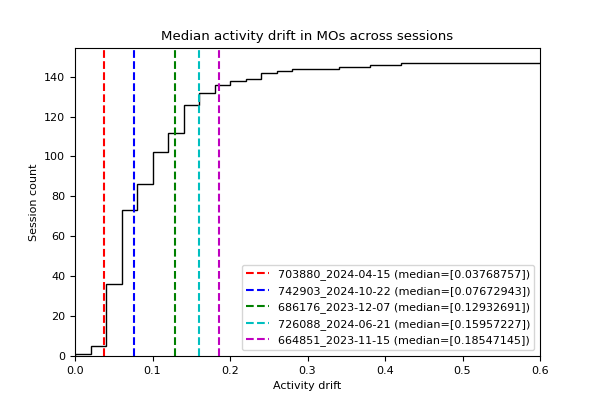

In [79]:
fig,ax=plt.subplots(figsize=(6,4))
ax.hist(drift_by_session['activity_drift'],bins=np.arange(0,1.02,0.02),color='k',cumulative=True,histtype='step')
ax.set_title(f'Median activity drift in {sel_area} across sessions')
ax.set_xlabel('Activity drift')
ax.set_ylabel('Session count')

sel_sessions=['703880_2024-04-15','742903_2024-10-22','686176_2023-12-07','726088_2024-06-21','664851_2023-11-15']

sel_colors=['r','b','g','c','m']

for ss,session_id in enumerate(sel_sessions):
    drift_value=drift_by_session.query('session_id==@session_id')['activity_drift'].values
    ax.axvline(x=drift_value,color=sel_colors[ss],linestyle='--',
               label=f'{session_id} (median={drift_value})')
    ax.legend(loc='lower right',fontsize=8)
    
ax.set_xlim([0,0.6])

In [80]:
# f'{session_id} (median={drift_by_session.query('session_id==@session_id')['activity_drift']})
# drift_by_session.query('session_id==@session_id')['activity_drift']
# sel_sessions
# drift_value

In [89]:
# drift_by_session.query('activity_drift<=1.0 and activity_drift>0.15').sort_values(by='activity_drift',ascending=False)
drift_by_session

,session_id,date,activity_drift,presence_ratio,isi_violations_ratio,amplitude_cutoff,fraction_sua,fraction_mua,fraction_noise,n_total_units
0,620263_2022-07-26,2022-07-26,0.240707,0.951613,0.000000,0.000412,0.647059,0.345588,0.007353,136
1,620263_2022-07-27,2022-07-27,0.284903,0.934426,0.004326,0.000495,0.743169,0.248634,0.008197,366
2,620264_2022-08-02,2022-08-02,0.118381,0.984127,0.000000,0.000272,0.623853,0.344037,0.032110,218
3,626791_2022-08-15,2022-08-15,0.109759,0.868421,0.000000,0.000349,0.569149,0.409574,0.021277,376
4,626791_2022-08-16,2022-08-16,0.172881,0.949367,0.043489,0.000225,0.557522,0.398230,0.044248,113
...,...,...,...,...,...,...,...,...,...,...
144,742903_2024-10-22,2024-10-22,0.076729,0.828125,0.000000,0.000313,0.599462,0.383513,0.017025,1116
145,743199_2024-12-04,2024-12-04,0.069569,1.000000,2.783195,0.000109,0.000000,0.100000,0.900000,10
146,743199_2024-12-05,2024-12-05,0.066487,0.991379,0.015046,0.000156,0.731959,0.250000,0.018041,388
147,743199_2024-12-06,2024-12-06,0.065238,1.000000,0.015803,0.000167,0.715000,0.275000,0.010000,200


In [22]:
drift_by_session.query('session_id.str.contains("2024-10-22")')

,session_id,activity_drift,presence_ratio,isi_violations_ratio,amplitude_cutoff,fraction_sua,fraction_mua,fraction_noise,n_total_units
144,742903_2024-10-22,0.076729,0.828125,0.0,0.000313,0.599462,0.383513,0.017025,1116


In [ ]:
sel_sessions=['703880_2024-04-15','742903_2024-10-22','686176_2023-12-07','664851_2023-11-15','726088_2024-06-21']#,'741148_2024-10-16']

In [65]:
pd.read_parquet(npc_lims.get_cache_path('performance',version='0.0.265',session_id='726088_2024-06-21'))['cross_modal_dprime']

id
0    1.915192
1    0.678412
2    1.619856
3    0.692096
4    2.285521
5    1.420655
Name: cross_modal_dprime, dtype: float64

In [10]:
all_units['decoder_label'].value_counts()

decoder_label
sua      330326
mua      211939
noise     32216
Name: count, dtype: int64

Text(0, 0.5, 'Activity drift')

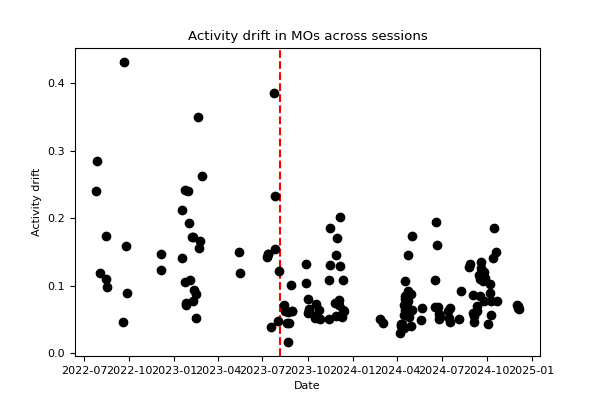

In [73]:
#plot activity drift versus date

date_threshold=dt.datetime.strptime('2023-08-05','%Y-%m-%d').date()

fig,ax=plt.subplots(figsize=(6,4))
ax.axvline(x=date_threshold,color='r',linestyle='--')
ax.plot(drift_by_session['date'],drift_by_session['activity_drift'],'o',color='k')
ax.set_title(f'Activity drift in {sel_area} across sessions')
ax.set_xlabel('Date')
ax.set_ylabel('Activity drift')

In [50]:
import datetime as dt

datestr=session_id[7:]
dt.datetime.strptime(datestr,'%Y-%m-%d').date()

datetime.date(2024, 11, 6)

In [48]:
session_id[7:]

'2024-11-06'